Homework 3 (final project)
===================================

In [1]:
using PyPlot
using LinearAlgebra
using Statistics
using DelimitedFiles
using Distributions
using KernelDensity



# Univariate simulators

Gaussian(mu::Real, Theta::Real) = mu + sqrt(Theta) \ randn()

function Wishart(phi::Real, Phi::Real)
    d  = 1
    n  = Int(2phi)
    @assert n == 2phi "first argument must be Integer/2"
    @assert phi > d/2 - 1/2 "first argument must be > d/2 - 1/2"
    (2Phi) \ sum(randn(n).^2)
end

# Multivariate simulators

function Gaussian_d(mu::Vector, Theta::Symmetric)
    d  = size(Theta,1)
    Theta½ = sqrt(Theta)
    mu + Theta½ \ randn(d)
end

function Wishart_d(phi::Real, Phi::Symmetric)
    n  = Int(2phi)
    d  = size(Phi,1)
    @assert n == 2phi "first argument must be Integer/2"
    @assert phi > d/2 - 1/2 "first argument must be > d/2 - 1/2"
    iW = zeros(d,d)
    zi = zeros(d)
    for i=1:n
        zi  .= randn(d)
        iW .+= zi * zi'
    end
    twPhi½ = sqrt(Symmetric(2Phi))
    return Symmetric(twPhi½ \ iW / twPhi½)
end

# Misc

function viridis_colors(;length=10)
    array_rgba = plt.cm.get_cmap("viridis", length)(range(0,1,length=length))
    return collect(eachrow(array_rgba))
end


function nearest_valid_phi(phi;d=1)
    lower_bound = d/2 - 1/2
    new_phi = round(2max(phi, lower_bound)) / 2
    if new_phi != phi
        @warn "Input phi = $phi, nearest valid phi = $new_phi"
    end
    return new_phi
end

nearest_valid_phi (generic function with 1 method)

Data
--------------------------

The data for this problem is in the file `data.csv`. Here is how to load it.

In [2]:
yi = readdlm("data.csv", ',')[:]

25-element Array{Float64,1}:
 -2017.7106233488373
 -2007.2408980724263
 -2005.1154014930028
 -2008.5117830345864
 -2025.5132574522222
 -2028.1854456826702
 -2010.5135720350138
 -2025.3244890587323
 -2018.6094268648226
 -2020.6825199021844
 -2008.568246172282
 -2011.299706617491
 -2043.3103043391645
 -2017.8271270156313
 -2027.1828129414023
 -1996.1439726063504
 -2037.4334342224986
 -2024.9749373753116
 -2021.822162447521
 -2024.1926752522218
 -2013.991961096987
 -2020.5517441255515
 -2034.3415531928802
 -2006.4170649918367
 -2041.705257535142

I simulated this data by first choosing two numbers $\mu$ and $\theta$.
Then I simulated 25 numbers as follows
$$
   y_1, y_2, \ldots, y_{25} \overset{iid}\sim Gaussian(\mu,\theta)
$$
Note: as we did in the lecture notes, $\theta$ represents inverse variance.

The goal of this homework is to try to infer the numbers $\mu$ and $1 / \theta$
using a Gibbs chain to sample from the posterior $p(\mu,\theta | y_1, \ldots, y_{25})$.

Use the following "semi-conjugate" prior defined by
$$
\begin{align}
p(\mu, \theta) &= p(\mu)p(\theta) \\
p(\mu) &= Gaussian(\mu|\varphi_1, \Phi_1) \\
p(\theta) &= Wishart(\theta|\varphi_2, \Phi_2)
\end{align}
$$
You will need to figure out some reasonable values of $\varphi_1, \varphi_2, \Phi_1, \Phi_2$.
Note, I recommend setting $\varphi_2$ to a value which has the form (positive integer) / 2
so it is easy to simulate from.

### Grading
Nominally this homework is worth 5 points. To get these 5 points you need to have:
 - Plots of the samples from the Gibbs chain (at least 1000 steps) for both variables $\mu$ and $\theta$
 - Histograms of the $\mu$ and $\theta$ values from the Gibbs chain (also a histogram of $1 / \theta$)
 - A bivariate scatter plot of the pairs $(\mu, \theta)$ from the Gibbs chain.
 - The code needs to run and does everything "by hand" (so doesn't call to Stan.jl or anything black box)
 - I would also like to see some statements at the end that argue what you think I could have picked for $\mu$ and $1 / \theta$

Note: I reserve the right to give bonus points to those students who go above and beyond the
nominal requirements listed above.

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*

#  Quick plot of the data



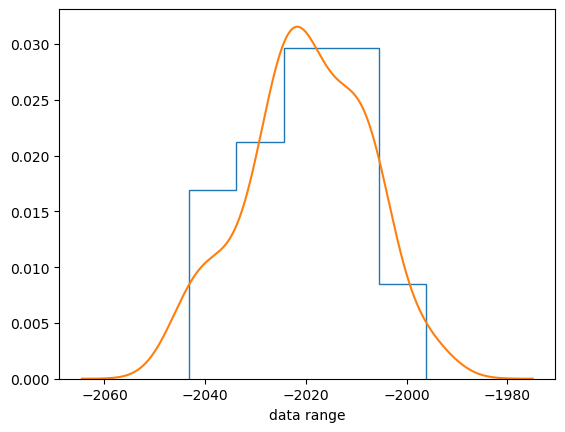

PyObject Text(0.5, 24.0, 'data range')

In [3]:
fig,ax = subplots(1)

ys = range(extrema(yi)..., length=1000)
ax.hist(yi, bins = 5, density=true, histtype = "step")

kde_yi = kde(yi)
ax.plot(kde_yi.x, kde_yi.density)

ax.set_xlabel("data range")

From the density plot, it seems that  the data is centered at -2020

Set the prior parameter
--------------------------

In [4]:
yΦ, logpriorθ, logpriorμ = let yi=yi
    d = length(yi[1])

    # prior μ ∼ Gaussian(φ₁, Phi₁)
    # prior θ ∼ Wishart(φ₂, Phi₂)
    
    
    
    yΦ = (
        φ₁   = 0.0,          
        Phi₁ = 1/1000.0^2,
        φ₂   = 1.5,         
        Phi₂ = 5.0,         
        yi = yi,
        n  = length(yi),
        ȳ  = mean(yi),
    )

    # Note: be sure to reason about what values are reasonable for 
    # φ₁, Phi₁, φ₂, Phi₂  I use the variables from demo.
    
    logpriorθ = θ -> (yΦ.φ₂-1)*log(θ) - yΦ.Phi₂*θ
    logpriorμ = μ -> - (yΦ.Phi₁/2) * (μ - yΦ.φ₁) ^ 2

    yΦ, logpriorθ, logpriorμ
end

((φ₁ = 0.0, Phi₁ = 1.0e-6, φ₂ = 1.5, Phi₂ = 5.0, yi = [-2017.7106233488373, -2007.2408980724263, -2005.1154014930028, -2008.5117830345864, -2025.5132574522222, -2028.1854456826702, -2010.5135720350138, -2025.3244890587323, -2018.6094268648226, -2020.6825199021844  …  -1996.1439726063504, -2037.4334342224986, -2024.9749373753116, -2021.822162447521, -2024.1926752522218, -2013.991961096987, -2020.5517441255515, -2034.3415531928802, -2006.4170649918367, -2041.705257535142], n = 25, ȳ = -2019.8868150750704), var"#5#7"{NamedTuple{(:φ₁, :Phi₁, :φ₂, :Phi₂, :yi, :n, :ȳ),Tuple{Float64,Float64,Float64,Float64,Array{Float64,1},Int64,Float64}}}((φ₁ = 0.0, Phi₁ = 1.0e-6, φ₂ = 1.5, Phi₂ = 5.0, yi = [-2017.7106233488373, -2007.2408980724263, -2005.1154014930028, -2008.5117830345864, -2025.5132574522222, -2028.1854456826702, -2010.5135720350138, -2025.3244890587323, -2018.6094268648226, -2020.6825199021844  …  -1996.1439726063504, -2037.4334342224986, -2024.9749373753116, -2021.822162447521, -2024.192

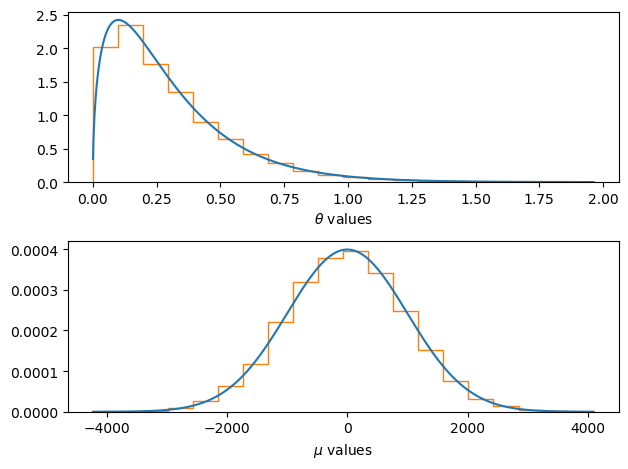

In [5]:
### Sample the prior to get an idea of the prior assumptions
fig, ax = subplots(2)

θi  = [Wishart(yΦ.φ₂, yΦ.Phi₂) for i=1:10000]
θs = range(minimum(θi),stop=maximum(θi),length=1000)
logpriorθs   = logpriorθ.(θs)
logpriorθs .-= maximum(logpriorθs)
priorθs      = exp.(logpriorθs)
priorθs    ./= sum(priorθs .* (θs[2]-θs[1]))
ax[1].plot(θs, priorθs)
ax[1].hist(θi, bins = 20, density=true, histtype = "step")
ax[1].set_xlabel(L"$\theta$ values")

μi  = [Gaussian(yΦ.φ₁, yΦ.Phi₁) for i=1:10000]
μs = range(minimum(μi),stop=maximum(μi),length=10000)
logpriorμs   = logpriorμ.(μs)
logpriorμs .-= maximum(logpriorμs)
priorμs      = exp.(logpriorμs)
priorμs    ./= sum(priorμs .* (μs[2]-μs[1]))
ax[2].plot(μs, priorμs)
ax[2].hist(μi, bins = 20, density=true, histtype = "step")
ax[2].set_xlabel(L"$\mu$ values")

fig.tight_layout()

# gibbs functions

In [6]:

 function simμ(θ, yΦ)
     ȳ, n     = yΦ.ȳ, yΦ.n
     φ₁, Phi₁ = yΦ.φ₁, yΦ.Phi₁


    θ_1 = Phi₁ + n * θ
    u_1 = (φ₁ * Phi₁ + n * θ * ȳ) / θ_1
    
    
    
     return Gaussian(u_1, θ_1)
 end
# 
#
 function simθ(μ, yΦ)
     yi, n    = yΦ.yi, yΦ.n
     φ₂, Phi₂ = yΦ.φ₂, yΦ.Phi₂

    φ₂_new = φ₂ + n / 2
    Phi₂_new = Phi₂ + sum((yi .- μ) .^ 2) ./ 2
     return Wishart(φ₂_new, Phi₂_new)
 end
#
#
 function gibbs(yΦ; μ_init = 0.0, nsteps=500)
     θchain = zeros(nsteps)
     μchain = zeros(nsteps)
     μ = μ_init
     θ= 1.0

     for i=1:nsteps

         μ = simμ(θ, yΦ)
         θ = simθ(μ, yΦ)         
         μchain[i] = μ
         θchain[i] = θ
     end
     return θchain, μchain
 end
# 
#
# Feel free to use copy this structure with your own details filled in.


gibbs (generic function with 1 method)

# Run the gibbs chain

In [7]:
 yΦ = (
        φ₁   = 0.0,          
        Phi₁ = 1/1000.0^2,
        φ₂   = 1.5,         
        Phi₂ = 5.0,         
        yi = yi,
        n  = length(yi),
        ȳ  = mean(yi),
    )

θchain, μchain = gibbs(yΦ, μ_init = mean(yi), nsteps = 1000)

([0.006162732416414681, 0.010796006715661466, 0.006503220156173058, 0.006362393035143663, 0.00824428270073555, 0.009356992049805845, 0.005406922086951407, 0.010691788683191355, 0.012428877006109494, 0.006935977793736439  …  0.010332941144318281, 0.009416937946965026, 0.006937217893297985, 0.008266802515370025, 0.01138683142208521, 0.00584550849762938, 0.010536818923713193, 0.009202361891603058, 0.00767537804585528, 0.009590012755445403], [-2019.964107152187, -2023.1401258978476, -2018.3356960258336, -2018.9478155376378, -2020.0992066584013, -2017.0641099637382, -2016.7105575222079, -2018.6479948948206, -2017.1382495185649, -2017.1463865171097  …  -2022.4570607335936, -2018.5661753122963, -2018.1280060211059, -2024.3627696322656, -2021.7440935446562, -2016.6937593718944, -2018.0732732196043, -2018.4712615811836, -2019.8300338620768, -2018.1101067564166])

# Plot the results

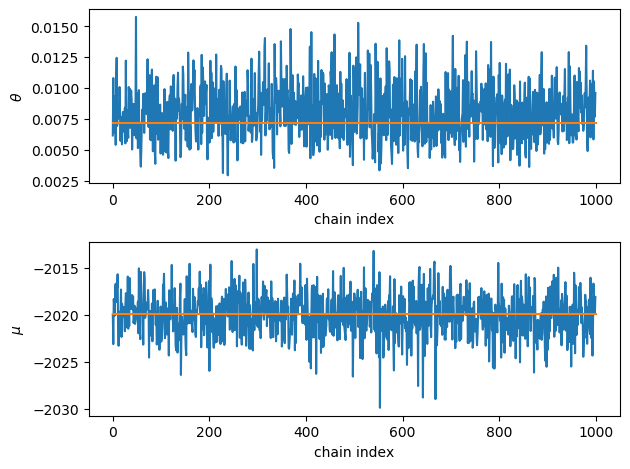

In [8]:
#Plots of the samples from the Gibbs chain (at least 1000 steps) for both variable 𝜇 and θ
 

fig, ax = subplots(2)

burnin = 1
nsteps = length(θchain[burnin:end])

ax[1].plot(θchain[burnin:end])
ax[1].plot(1:nsteps, fill(1/var(yΦ.yi),nsteps) )
ax[1].set_ylabel(L"\theta")
ax[1].set_xlabel("chain index")


ax[2].plot(μchain[burnin:end])
ax[2].plot(1:nsteps, fill(yΦ.ȳ, nsteps) )
ax[2].set_ylabel(L"\mu")
ax[2].set_xlabel("chain index")

fig.tight_layout()

Histograms of the $\mu$ and $\theta$ values from the Gibbs chain also a histogram of $1 / \theta$ 

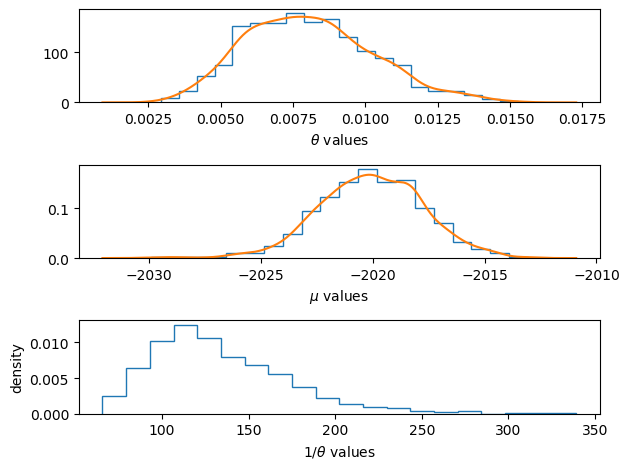

In [18]:
fig, ax = subplots(3)

burnin = 100
nsteps = length(θchain[burnin:end])


kdeμ = kde(μchain[burnin:end])
ax[2].hist(μchain[burnin:end], bins = 20, density=true, histtype = "step")
ax[2].plot(kdeμ.x, kdeμ.density)
ax[2].set_xlabel(L"$\mu$ values")

kdeθ = kde(θchain[burnin:end])
ax[1].hist(θchain[burnin:end], bins = 20, density=true, histtype = "step")
ax[1].plot(kdeθ.x, kdeθ.density)
ax[1].set_xlabel(L"$\theta$ values")



kdeθ = kde(θchain[burnin:end])
ax[3].hist(1 ./ θchain[burnin:end], bins = 20, density=true, histtype = "step")
ax[3].set_xlabel(L"$1/\theta$ values")
ax[3].set_ylabel("density")

fig.tight_layout()

A bivariate scatter plot of the pairs $(\mu, \theta)$ from the Gibbs chain.

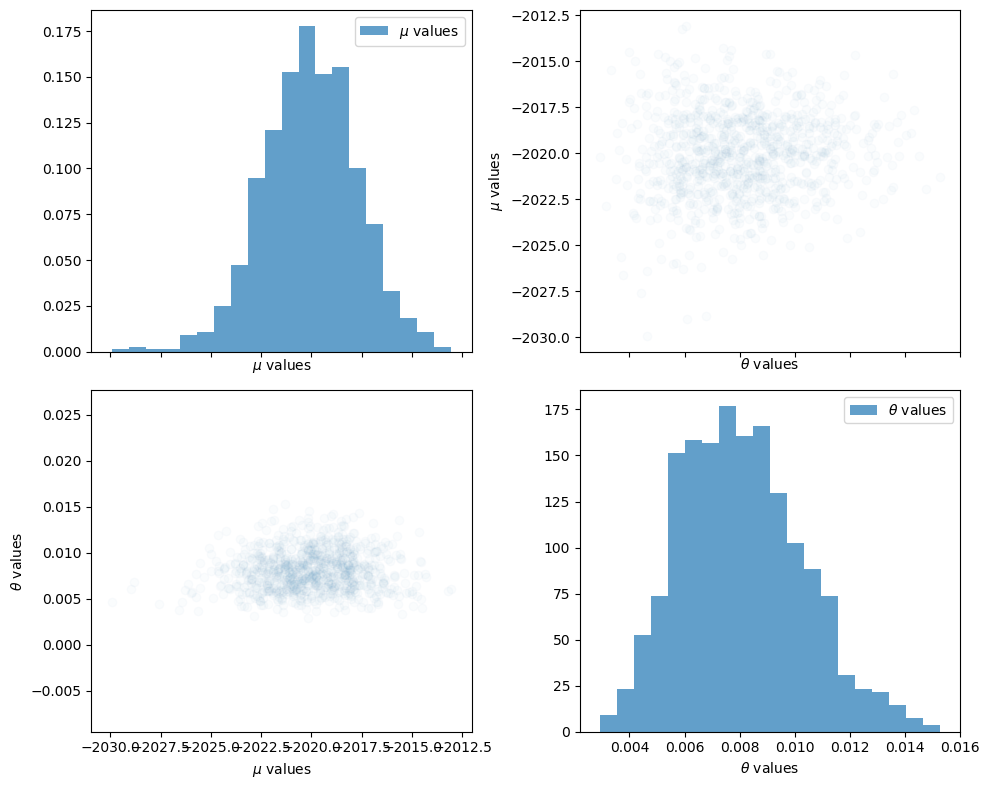

In [10]:
fig, ax = plt.subplots(2, 2, figsize=(10, 8), sharex="col") # , sharey=true)
burnin = 100
nsteps = length(θchain[burnin:end])
# column 1: βi on the xaxis
ax[1,1].set_xlabel(L"$\mu$ values")
ax[2,1].set_xlabel(L"$\mu$ values")
ax[2,1].set_ylabel(L"$\theta$ values")
ax[1,1].hist(μchain[burnin:end], bins = 20, alpha = 0.7, label=L"$\mu$ values", density=true)
ax[2,1].scatter(μchain[burnin:end], θchain[burnin:end], alpha = 0.02)
# column 2: βj on the xaxis
ax[2,2].set_xlabel(L"$\theta$ values")
ax[1,2].set_xlabel(L"$\theta$ values")
ax[1,2].set_ylabel(L"$\mu$ values")
ax[2,2].hist(θchain[burnin:end], bins = 20, alpha = 0.7, label=L"$\theta$ values", density=true)
# kdeθμ = kde((θchain[burnin:end], μchain[burnin:end]))
# ax[1,2].pcolormesh(kdeθμ.x, kdeθμ.y, kdeθμ.density)
ax[1,2].scatter(θchain[burnin:end], μchain[burnin:end], alpha = 0.02)

ax[1,1].legend()
# ax[1,2].legend()
ax[2,2].legend()
#ax[2,1].legend()
fig.tight_layout()

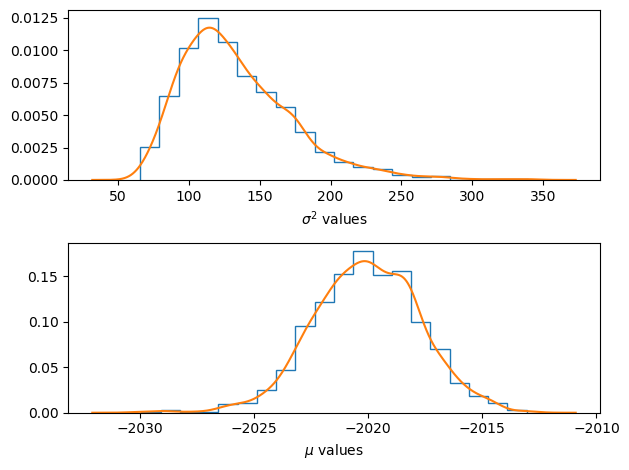

In [11]:
fig, ax = subplots(2)

burnin = 100
nsteps = length(θchain[burnin:end])

kdeσ² = kde(1 ./ θchain[burnin:end])
ax[1].hist(1 ./ θchain[burnin:end], bins = 20, density=true, histtype = "step")
ax[1].plot(kdeσ².x, kdeσ².density)
ax[1].set_xlabel(L"$\sigma^2$ values")

kdeμ = kde(μchain[burnin:end])
ax[2].hist(μchain[burnin:end], bins = 20, density=true, histtype = "step")
ax[2].plot(kdeμ.x, kdeμ.density)
ax[2].set_xlabel(L"$\mu$ values")

fig.tight_layout()

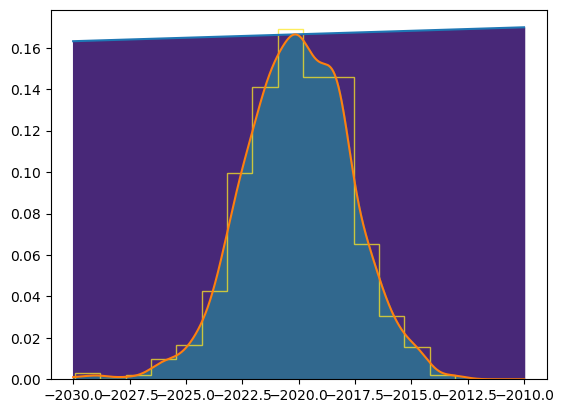

PyObject <matplotlib.collections.PolyCollection object at 0x157ad4b90>

In [12]:
# plot the prior along with a kde estimate of the posterior

##let yΦ = yΦ,  chain=θchain[100:end], logprior = logpriorθ
let yΦ = yΦ,  chain=μchain[100:end], logprior = logpriorμ

    post = kde(chain)
    xs = range(-2030, stop=-2010, length=10_000) # you pick the range here
    
    fig,ax = subplots(1)
    clr  = viridis_colors(;length=10)

    logpriorxs   = logprior.(xs)
    # -----
    logpriorxs .-= logpriorxs[argmax(pdf(post, xs))]
    logpriorxs .+= log(maximum(post.density))
    priorxs      = exp.(logpriorxs)

    ax.hist(chain, density=true, histtype="step", bins = 15, color=clr[end], alpha=0.75)

    ax.plot(xs, priorxs)
    #ax.plot(xs, post.density)
    ax.plot(xs, pdf(post,xs))

    ax.fill_between(xs, priorxs, 0.0, color=clr[2])
    ax.fill_between(xs, pdf(post,xs), 0.0, color=clr[4])

end

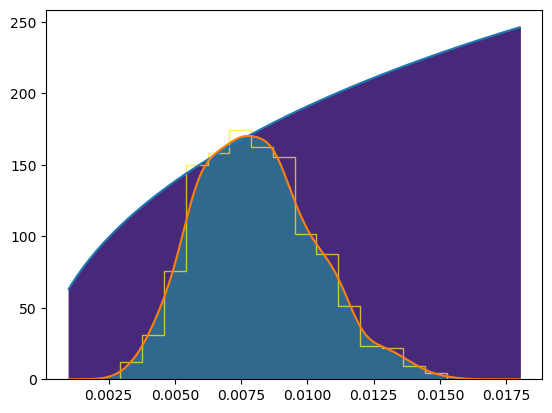

PyObject <matplotlib.collections.PolyCollection object at 0x1590c1690>

In [13]:
# plot the prior along with a kde estimate of the posterior

let yΦ = yΦ,  chain=θchain[100:end], logprior = logpriorθ

    post = kde(chain)
    xs = range(0.001, stop=0.018, length=10_000) # you pick the range here
    
    fig,ax = subplots(1)
    clr  = viridis_colors(;length=10)

    logpriorxs   = logprior.(xs)
    # -----
    logpriorxs .-= logpriorxs[argmax(pdf(post, xs))]
    logpriorxs .+= log(maximum(post.density))
    priorxs      = exp.(logpriorxs)

    ax.hist(chain, density=true, histtype="step", bins = 15, color=clr[end], alpha=0.75)

    ax.plot(xs, priorxs)
    ax.plot(xs, pdf(post,xs))

    ax.fill_between(xs, priorxs, 0.0, color=clr[2])
    ax.fill_between(xs, pdf(post,xs), 0.0, color=clr[4])
end

# True values of $\theta$ and $\mu$

The emperical density of $\mu$ peaks at $\mu = -2020$ and the emperical density of peaks at  $1/\theta =120 $(approximately from graph).

If we take the emperical densities for $1/\theta$ and $\mu$ as approximations to their true densities, then use the maximum a posteriori (MAP) estimation, then we would estimate $1/\theta=120$ and $\mu=-2020$.